In [3]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
sns.set_theme(context='notebook', style='white', font_scale=1.33)

import numpy as np
from os.path import dirname
from pandas import read_csv
import pandas as pd
from numba import njit
from tqdm import tqdm
import json

from os.path import exists



## Analysis

### get data

In [4]:
#set models,session to analyse
stan_models = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6']
stan_versions = ['a','b']
sessions = [1, 2, 3]

In [8]:
# get ppc
all_data = []
for stan_model in stan_models:
    for stan_version in stan_versions:
        for session in sessions:
            path_to_file = os.path.join('stan_results', 'ppc',
                            f'{stan_model}{stan_version}_s{session}_ppc.tsv')
            if exists(path_to_file):
                df = read_csv(path_to_file, sep='\t')
                df['model'] = stan_model
                df['version'] = stan_version
                all_data.append(df)
        
        
all_data = concat(all_data)



#### basic compartive plot1: Choice (true vs. predicted) over time - per model& session, split given context.

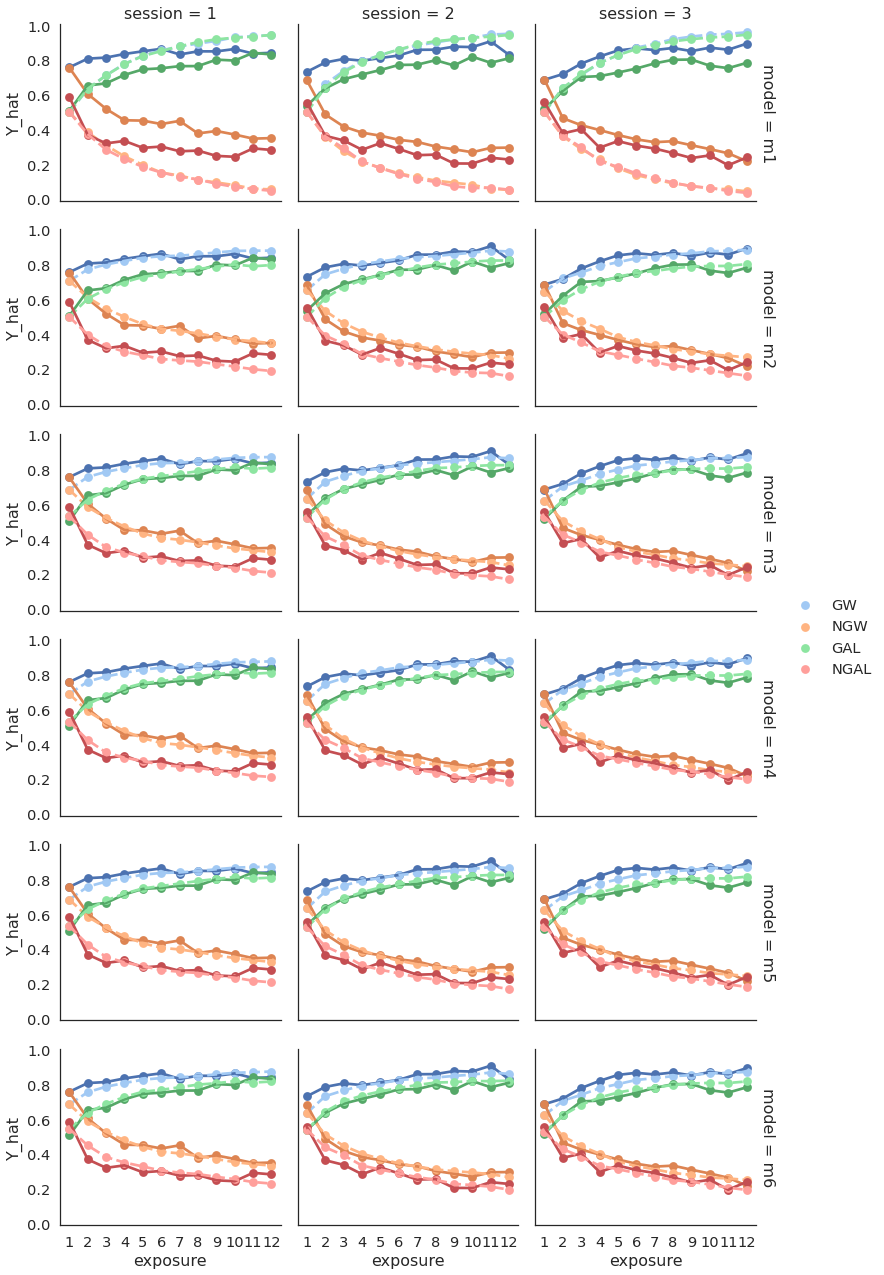

In [11]:
all_data_a = all_data[all_data.version=='a']

g = sns.FacetGrid(all_data_a, row='model', 
                  row_order=stan_models, col='session', 
                  margin_titles=True,
                  col_order=sessions, aspect=1.25, legend_out=True)

order = np.arange(12) + 1
hue_order = ['GW','NGW','GAL','NGAL']

g.map(sns.pointplot, 'exposure', 'choice', 'robot', 
      palette = sns.color_palette(),
      order=order, hue_order=hue_order, ci=None)

g.map(sns.pointplot, 'exposure', 'Y_hat', 'robot' , 
      palette = sns.color_palette("pastel"),
      order=order, hue_order=hue_order, ci=None, linestyles='--')

g.add_legend()



In [14]:
all_data_456 = all_data[all_data.model.isin(['m4','m5','m6'])]

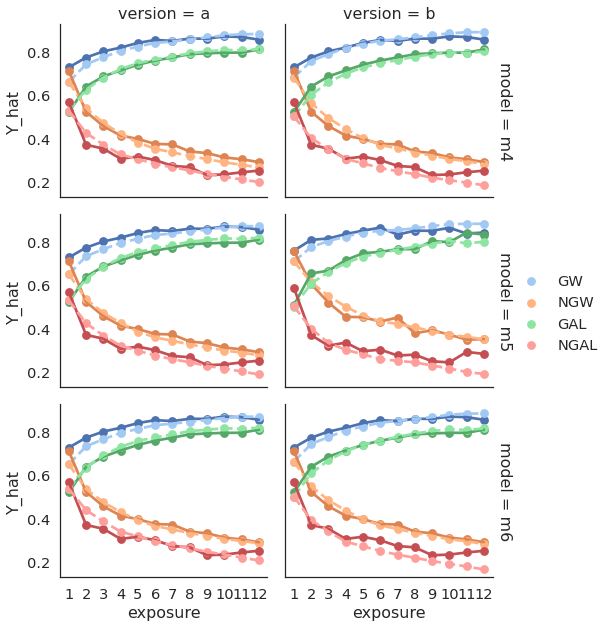

In [24]:

g1 = sns.FacetGrid(all_data_456, row='model', 
                  row_order=['m4','m5','m6'], col='version', 
                  margin_titles=True,
                  col_order=['a','b'], 
                   aspect=1.25, legend_out=True)

order = np.arange(12) + 1
hue_order = ['GW','NGW','GAL','NGAL']

g1.map(sns.pointplot, 'exposure', 'choice', 'robot', 
      palette = sns.color_palette(),
      order=order, hue_order=hue_order, ci=None)

g1.map(sns.pointplot, 'exposure', 'Y_hat', 'robot' , 
      palette = sns.color_palette("pastel"),
      order=order, hue_order=hue_order, ci=None, linestyles='--')

g1.add_legend()



#### basic compartive plot2: True choice vs. predicted choice - per model, split given context.

In [26]:
gb_choice_a = all_data_a.groupby(['model','version','session','subject','robot']).\
            agg({'choice':'mean', 'Y_hat':'mean'}).reset_index()

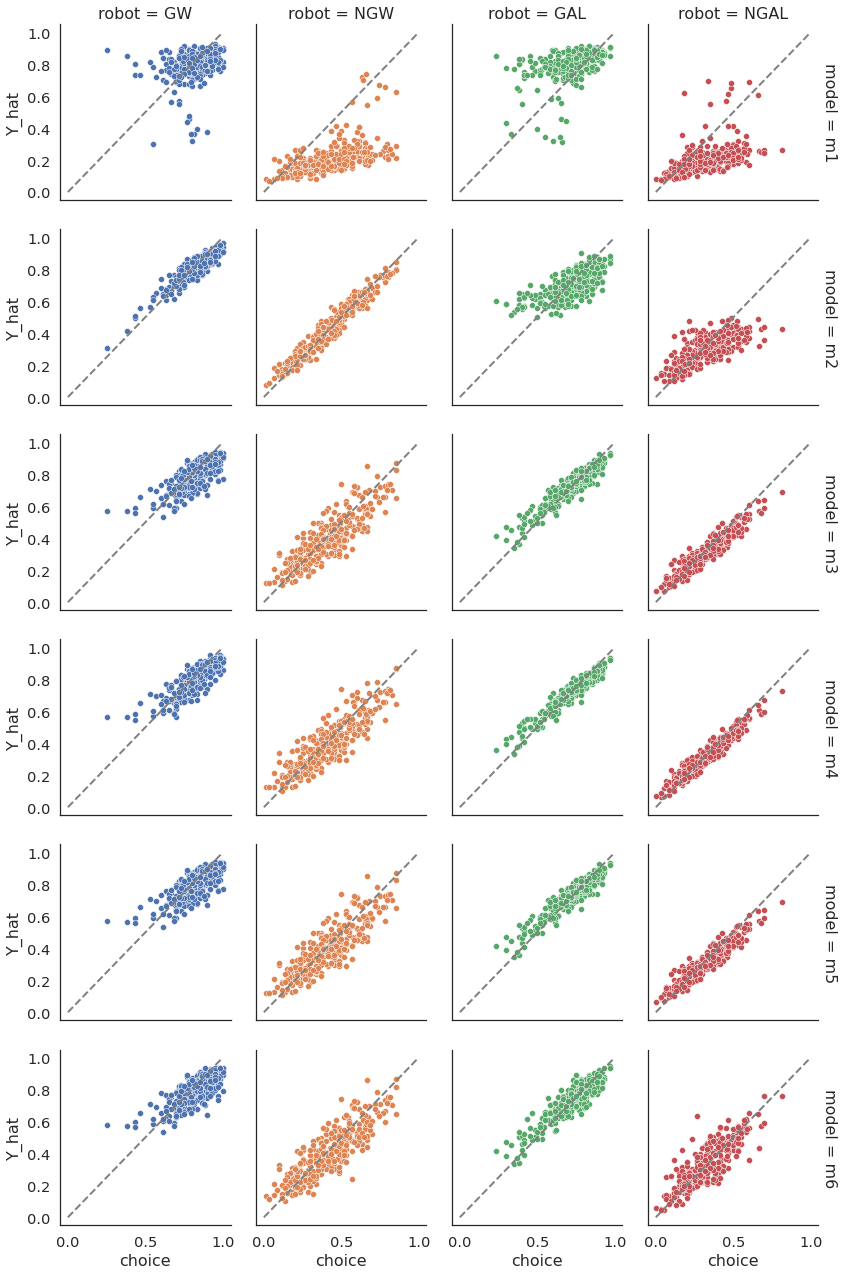

In [27]:

g11 = sns.FacetGrid(gb_choice_a, row = 'model', hue='robot', 
                   hue_order=hue_order, margin_titles=True,
                  row_order = stan_models, col = 'robot', 
                  col_order = ['GW','NGW','GAL','NGAL'], 
                  palette = sns.color_palette())

g11.map(sns.scatterplot, 'choice', 'Y_hat',  )


for ax in g11.axes.ravel():
    ax.plot([0,1], [0,1],
           color='grey', 
           linestyle='--',
           linewidth = 2)



In [ ]:
## no beta go

In [33]:
gb_choice_456b = all_data_456.groupby(['model','version','session','subject','robot']).\
            agg({'choice':'mean', 'Y_hat':'mean'}).reset_index()

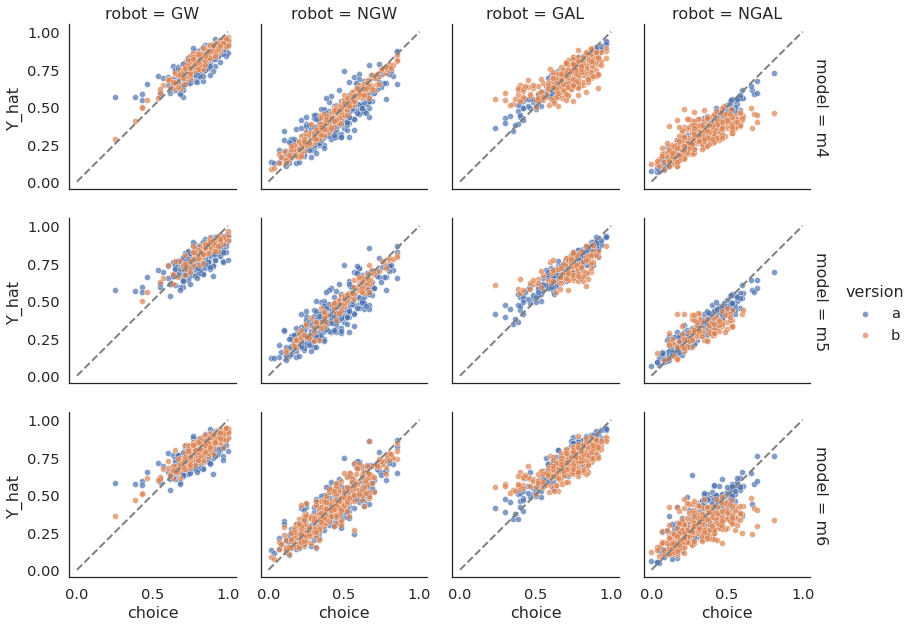

In [41]:

g14 = sns.FacetGrid(gb_choice_456b, row = 'model', hue='version', 
                   hue_order = ['a','b'], margin_titles=True,
                  row_order = ['m4','m5','m6'], col = 'robot', 
                  col_order = ['GW','NGW','GAL','NGAL'], 
                  palette = sns.color_palette())

g14.map(sns.scatterplot, 'choice', 'Y_hat',  alpha=.7)


for ax in g14.axes.ravel():
    ax.plot([0,1], [0,1],
           color='grey', 
           linestyle='--',
           linewidth = 2)

g14.add_legend()


In [7]:
all_data['acc_hat'] = (all_data.Y_hat.round() == all_data.correct) == all_data.accuracy

In [8]:
gb_acc = all_data.groupby(['model','session','subject','robot']).\
            agg({'accuracy':'mean', 'acc_hat':'mean'}).reset_index()

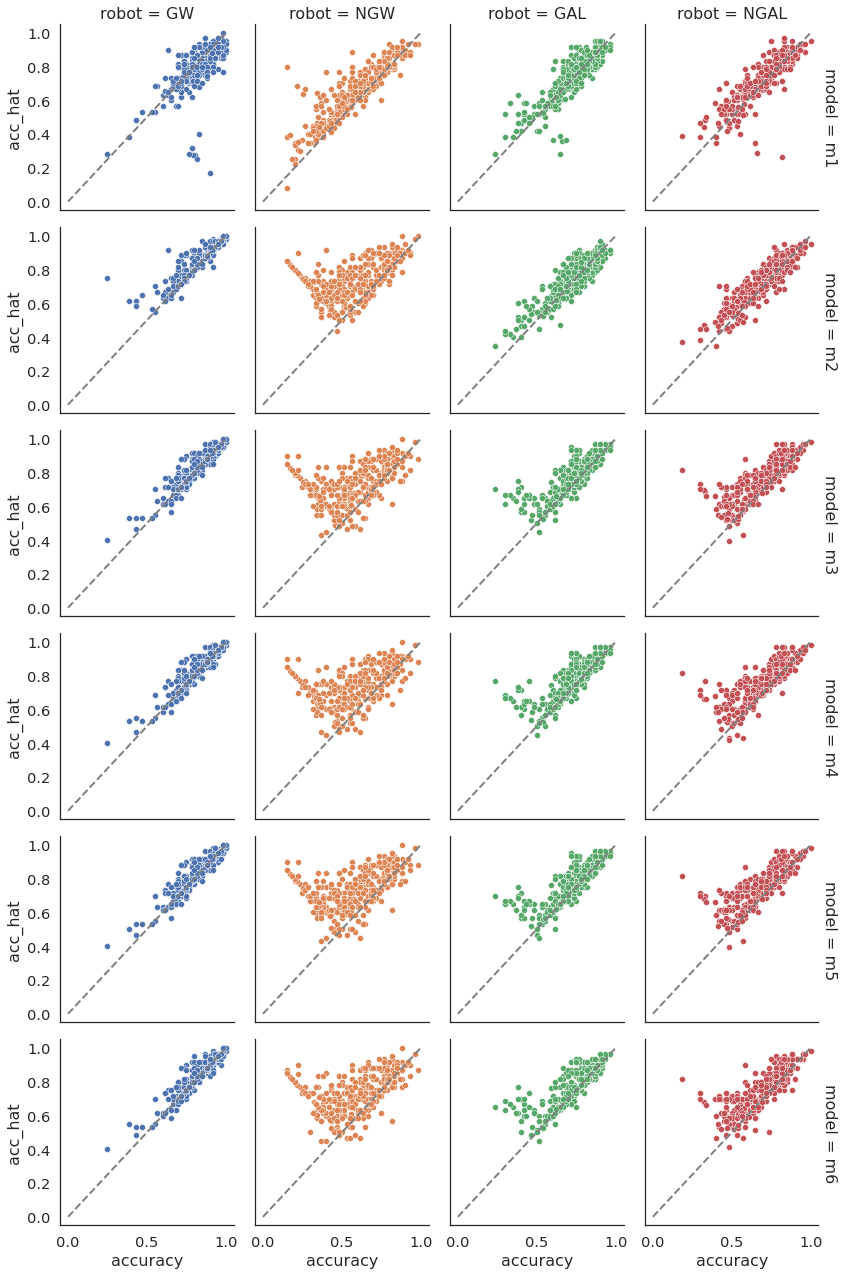

In [9]:
g2 = sns.FacetGrid(gb_acc, row = 'model', hue='robot', 
                   hue_order=hue_order, margin_titles=True,
                  row_order = stan_models, col = 'robot', 
                  col_order = ['GW','NGW','GAL','NGAL'], 
                  palette = sns.color_palette())

g2.map(sns.scatterplot, 'accuracy', 'acc_hat')


for ax in g2.axes.ravel():
    ax.plot([0,1], [0,1],
           color='grey', 
           linestyle='--',
           linewidth = 2)

#### waic

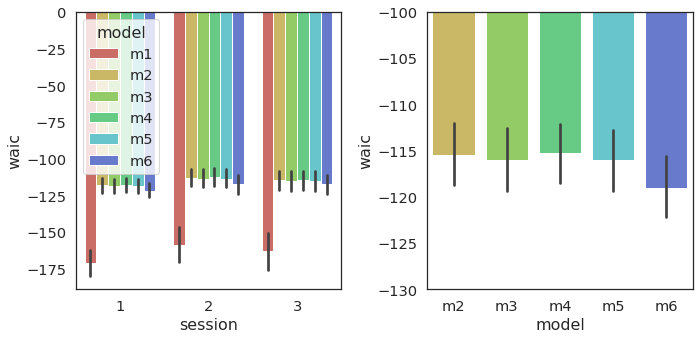

In [10]:
gb_waic = all_data.groupby(['model','session','subject']).waic.sum().reset_index()

f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

g3a = sns.barplot(x='session', y='waic', 
                  hue='model', data=gb_waic, ax=ax1,
                 palette = sns.color_palette("hls", 8))

g3b = sns.barplot(x='model', y='waic', 
                  palette = sns.color_palette("hls", 8)[1:],
                  data=gb_waic[gb_waic.model!='m1'], ax=ax2)

g3b.set_ylim(-130, -100)
plt.tight_layout()

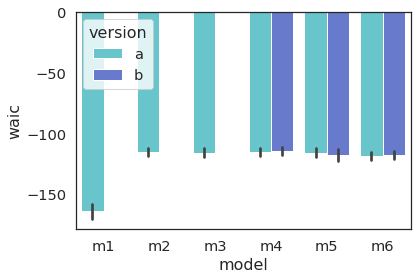

In [40]:
gb_waic_456 = all_data.groupby(['model','version','session','subject']).waic.sum().reset_index()

g3b_456 = sns.barplot(x='model', y='waic', hue='version',
                  palette = sns.color_palette("hls", 8)[4:],
                  data=gb_waic_456)

In [13]:
## m2 vs m3

In [13]:
## get subejecst with high b-go

with open('analysis_arrays/above_med_go_subjects.npy', 'rb') as f:
    above_med_go_subjects = np.load(f)
above_med_go_subjects = np.array(above_med_go_subjects,dtype=int) 

above_med_go_subjects_ids = np.array(list(set(all_data.subject)))[above_med_go_subjects-1]

# get ppc for top beta go 
def get_top_beta_go (row):
    if any(sb in row.subject for sb in above_med_go_subjects_ids):
        return True
    return False

all_data['above_med_beta_go'] = all_data.apply (lambda row: get_top_beta_go(row), axis=1)


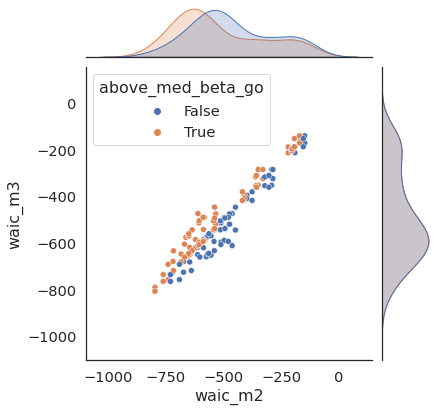

In [14]:

m2_waic = all_data[all_data.model=='m2'].groupby(['model','session','exposure','above_med_beta_go']).waic.sum().reset_index()
m3_waic = all_data[all_data.model=='m3'].groupby(['model','session','exposure','above_med_beta_go']).waic.sum().reset_index()

gb_waic1 = pd.merge(m2_waic[['session','exposure','waic','above_med_beta_go']],
         m3_waic[['session','exposure','waic']], 
         on=['session','exposure'], suffixes=('_m2', '_m3'))


ax1 = sns.jointplot(x='waic_m2',
                    y='waic_m3', 
                    hue='above_med_beta_go',
                   data=gb_waic1,
                   )


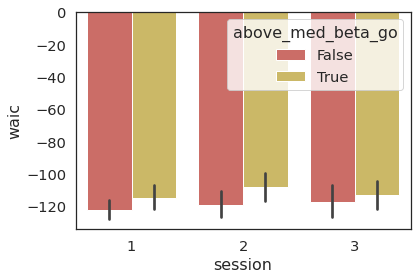

In [8]:
gb_waic_go_beta = all_data[all_data.model=='m3'].groupby(['above_med_beta_go','session','subject']).waic.sum().reset_index()


b2 = sns.barplot(x='session', y='waic', 
                  hue='above_med_beta_go', data=gb_waic_go_beta,
                 palette = sns.color_palette("hls", 8))
